<a href="https://colab.research.google.com/github/HarlinLee/BlobOT/blob/main/obstacles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"
FOLDER_PATH = 'obstacles'

import sys
sys.path.insert(0, DRIVE_PATH)

import numpy as np
import matplotlib.pyplot as plt
import torch

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
230527


In [ ]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
print(device)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

cpu
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
def get_grid_samples(nx):
  coord = (0, 1)

  y1s, y2s = np.meshgrid(np.linspace(coord[0], coord[1], nx), np.linspace(coord[0], coord[1], nx), indexing='ij')
  dat = []

  for i in range(nx):
    for j in range(nx):
      dat.append(np.array([y1s[i, j], y2s[i, j]]))

  return np.squeeze(np.array(dat))
  

def plot_2d_paths(X, w, z, params=None, figsize=(10, 5), fname='output.pdf', **kwargs):
  fig, ax = plt.subplots(1, 2, figsize=figsize)
  if X.shape[-1] <= L:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)
    
  z = X[:, :, 0]
  y = X[:, :, -1]

  obst_c1 = params['obst_c1']
  obst_c2 = params['obst_c2']
  obst_r = params['obst_r']

  obst1 = plt.Circle(obst_c1, obst_r, fill=True, alpha=0.7)
  obst2 = plt.Circle(obst_c2, obst_r, fill=True, alpha=0.7)
  ax[0].add_patch(obst1)
  ax[0].add_patch(obst2)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0].plot(traj[:, 0], traj[:, 1],  color=[.5, .5, 1])
    ax[0].scatter(traj[:, 0], traj[:, 1],  color=[.5, .5, 1], marker='o')
  
  ax[0].scatter(X[:, 0, 0], X[:, 1, 0], marker='+', c='b', label='Source')
  ax[0].scatter(w[:, 0], w[:, 1], marker='x', c='r', label='Target')
  
  obst1 = plt.Circle(obst_c1, obst_r, fill=True, alpha=0.7)
  obst2 = plt.Circle(obst_c2, obst_r, fill=True, alpha=0.7)
  ax[1].add_patch(obst1)
  ax[1].add_patch(obst2)

  ax[1].scatter(z[:, 0], z[:, 1], marker='+', c='b', label='Source')
  ax[1].scatter(w[:, 0], w[:, 1], marker='x', c='r', label='Target')
  ax[1].scatter(y[:, 0], y[:, 1], marker='.', c='k', label='x(1)')

  if params is not None:
    circlew = plt.Circle(params['center'].squeeze(), params['sigma'], fill=False, linestyle='--', edgecolor='r', alpha=0.3)
    ax[1].add_patch(circlew)

  plt.legend(fontsize=16, markerscale=2)
  plt.tight_layout(pad=0)
  plt.savefig(os.path.join(DRIVE_PATH, fname), dpi=300)
  

In [ ]:
from BlobOT import KE, NLE_gauss, obstacle, Model
from BlobOT import draw_straight_lines, EarlyStopping, endpoint_cost, allpoint_cost

def blobLoss(X, model):
  ke = KE(X, model.z, model.params)
  nle = NLE_gauss(X, model.w, model.params)
  o_val1 = obstacle(X, obst1_tensor, obst_r, model.params)
  o_val2 = obstacle(X, obst2_tensor, obst_r, model.params)

  return ke + nle + torch.sum(o_val1 + o_val2)/2

def training_loop(model, optimizer, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=2, threshold=0,
                                                         factor=0.2)
  early_stopping = EarlyStopping(patience=5)

  losses=[]

  for i in range(n):
    preds = model()
    loss = blobLoss(preds, model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)
    losses.append(loss.cpu().detach().numpy())

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return np.array(losses)
    
    if i % 1e4 == 0:
      print(i)
      X = model.X.data.cpu().detach().numpy()
      plot_2d_paths(X, w, z, params)
      plt.show()

  return np.array(losses)
                              

{'N': 25, 'd': 2, 'dt': 0.05, 'L': 20, 'delta': 0.04064898365069303, 'eps': 0.1, 'sigma': 0.2, 'lr': 0.0001, 'n': 200000, 'obst_r': 0.2, 'obst_c1': (1.25, 1.25), 'obst_c2': (0.9, 1.5), 'eps_obst': 0.0025000000000000005, 'center': array([[1.5, 1.7]])}
0


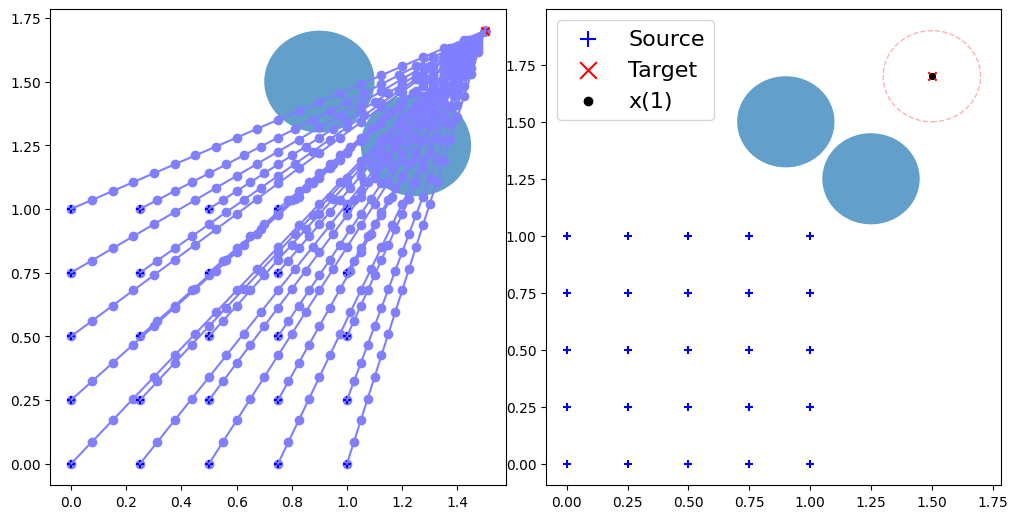

10000


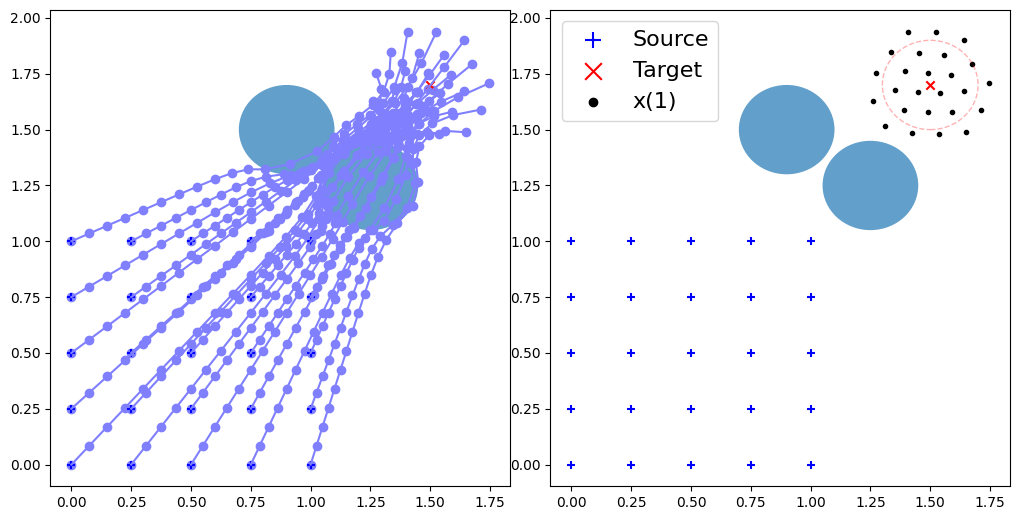

20000


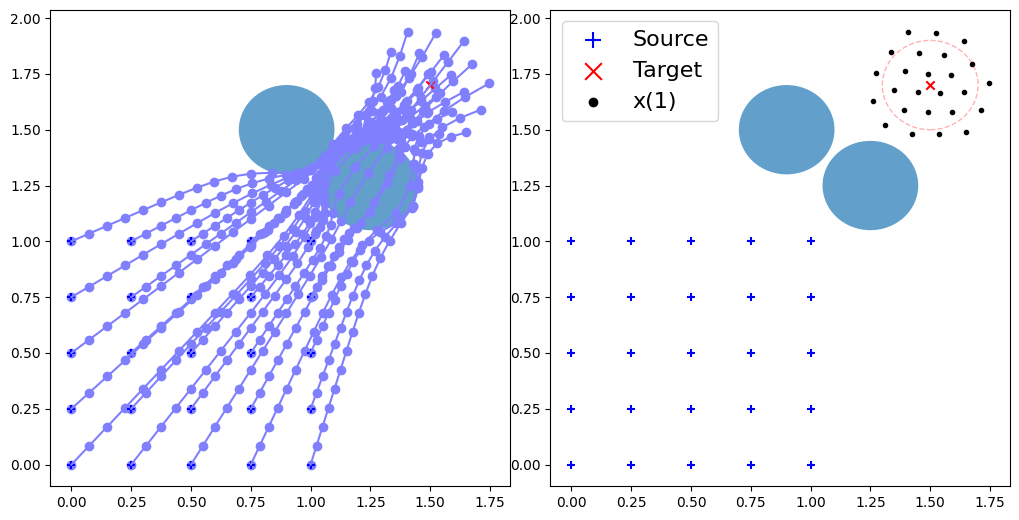

30000


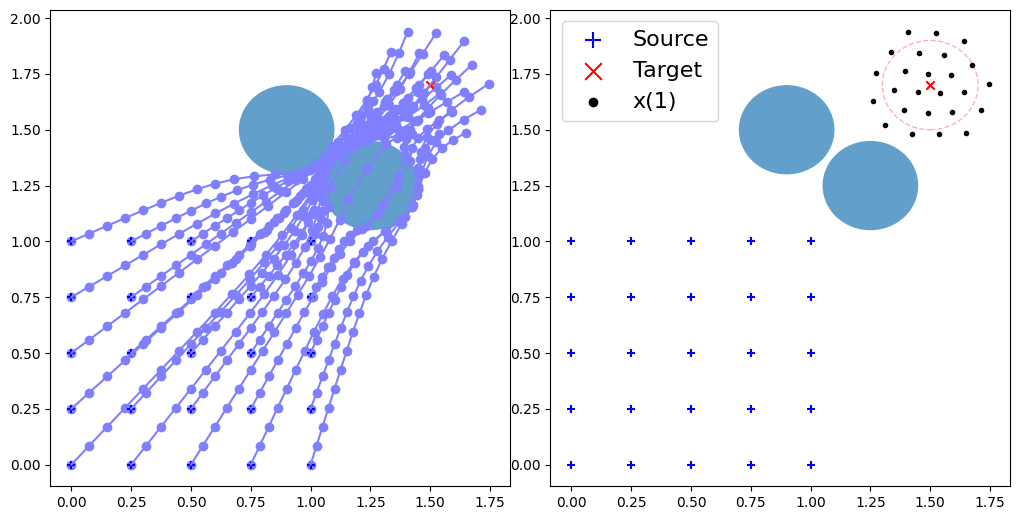

40000


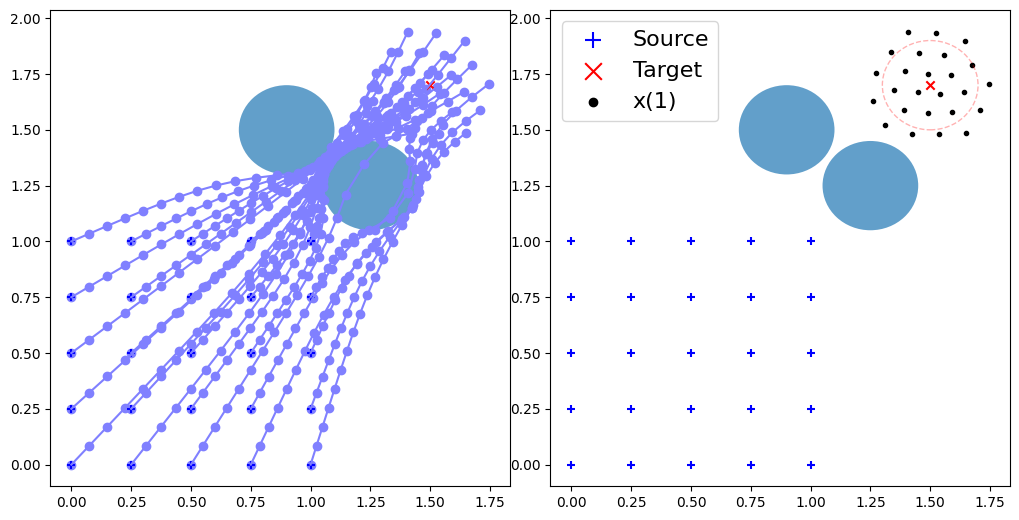

50000


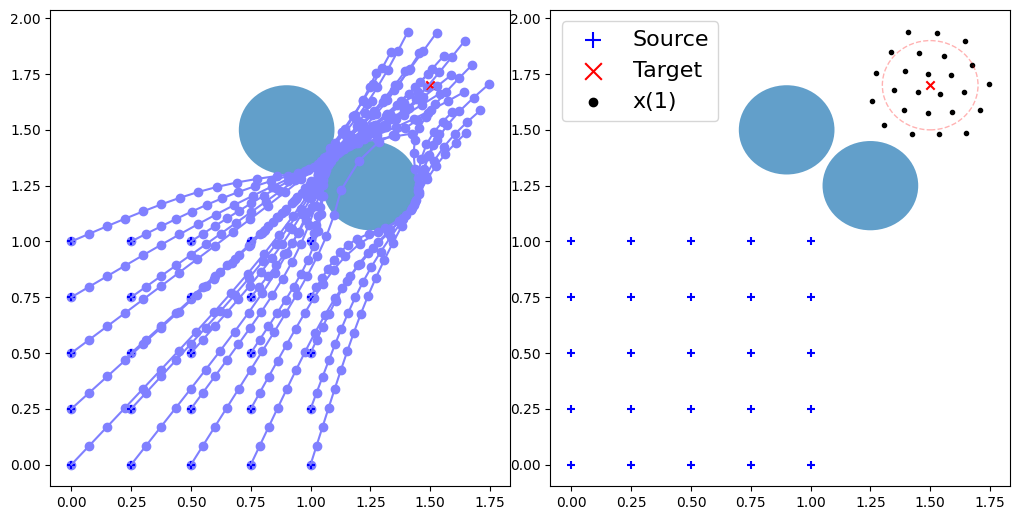

60000


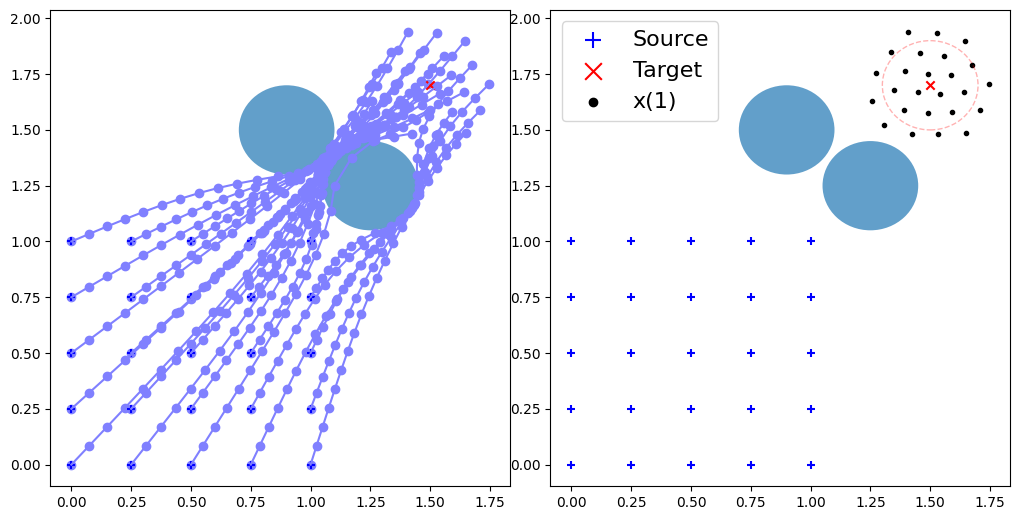

70000


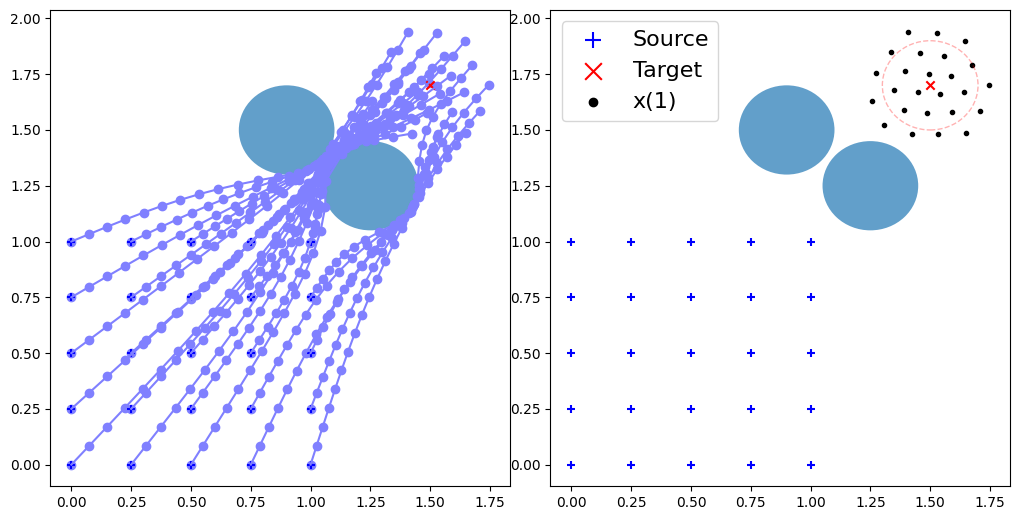

Epoch 76254: reducing learning rate of group 0 to 2.0000e-05.
Epoch 76389: reducing learning rate of group 0 to 4.0000e-06.
Epoch 77090: reducing learning rate of group 0 to 8.0000e-07.
Epoch 77261: reducing learning rate of group 0 to 1.6000e-07.
Epoch 78706: reducing learning rate of group 0 to 3.2000e-08.
80000


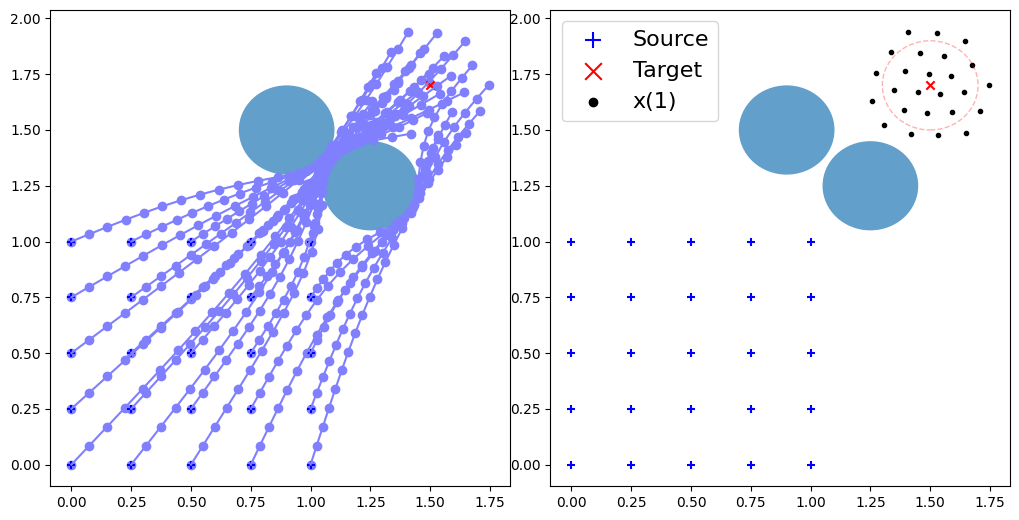

Epoch 80865: reducing learning rate of group 0 to 6.4000e-09.
90000


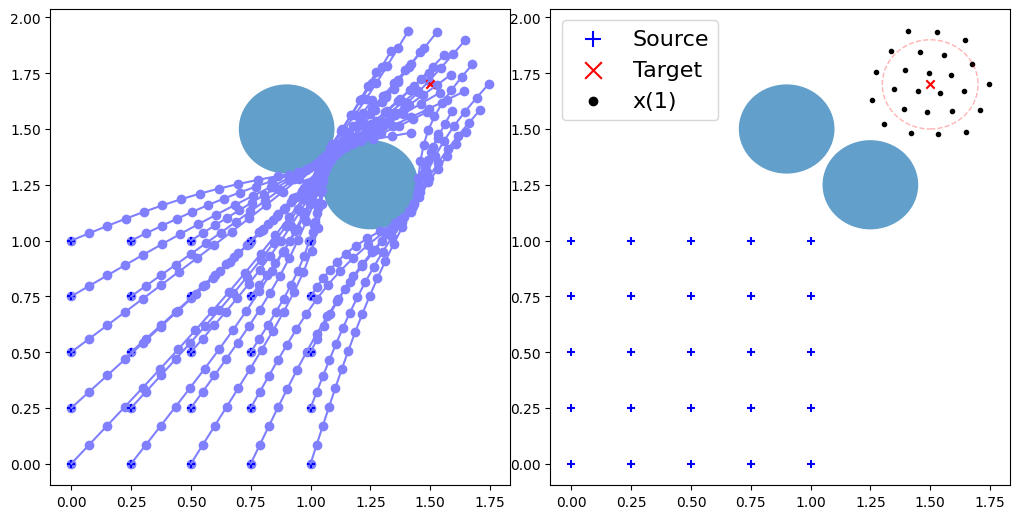

100000


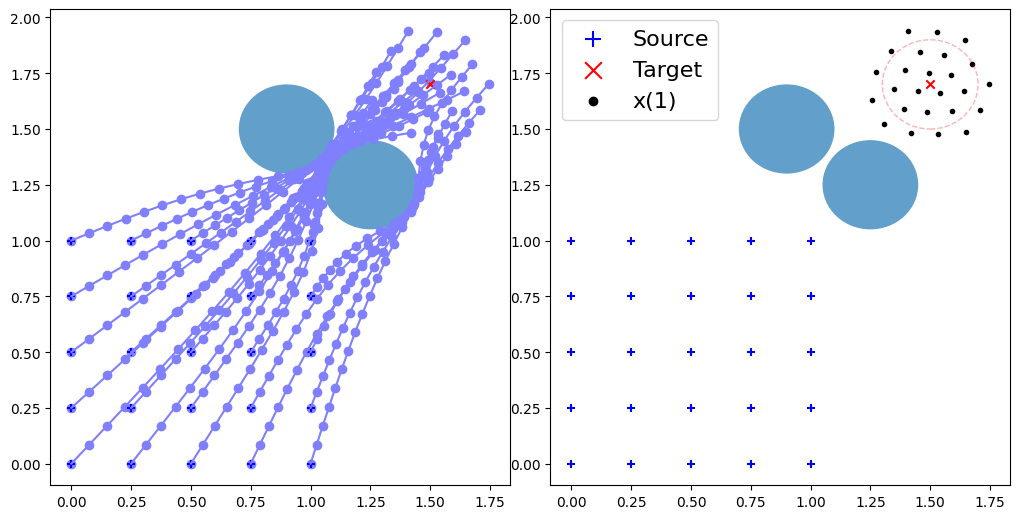

110000


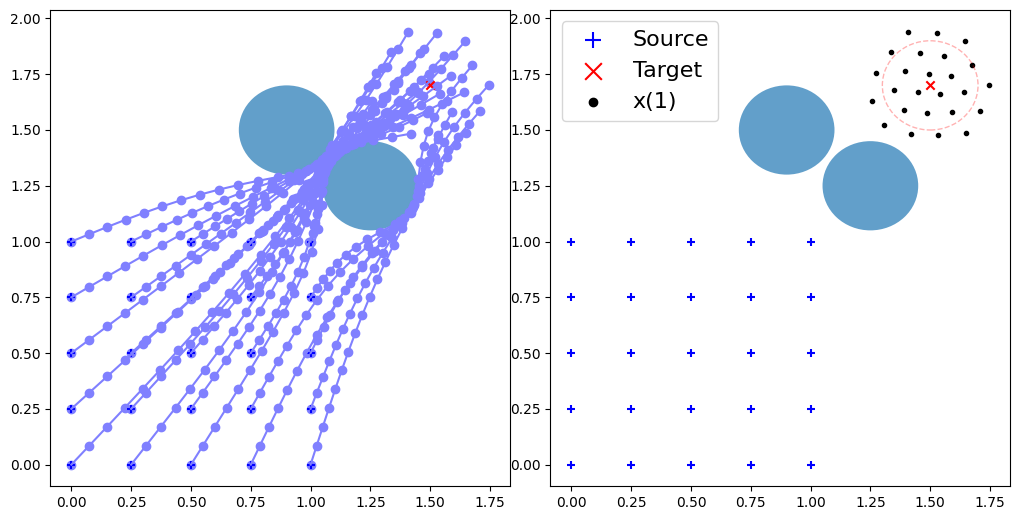

120000


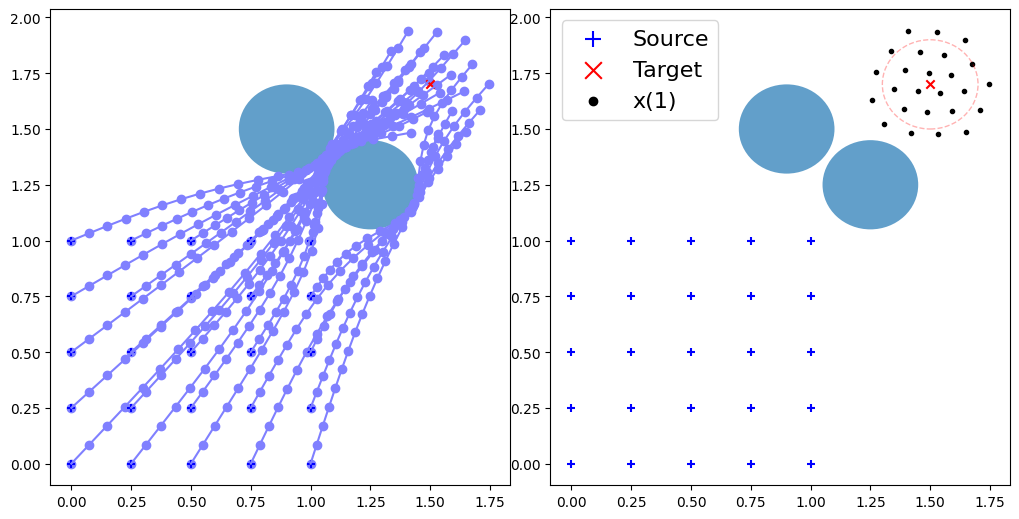

130000


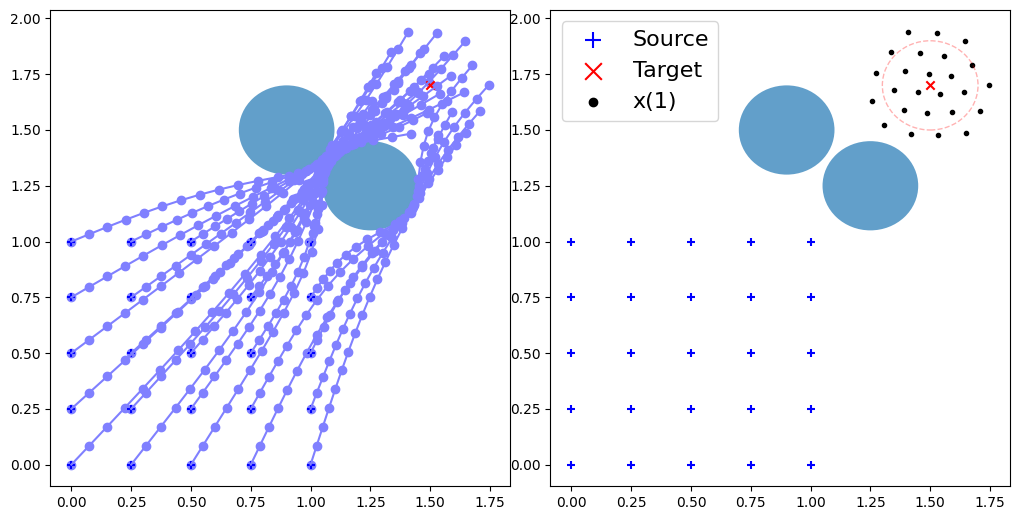

140000


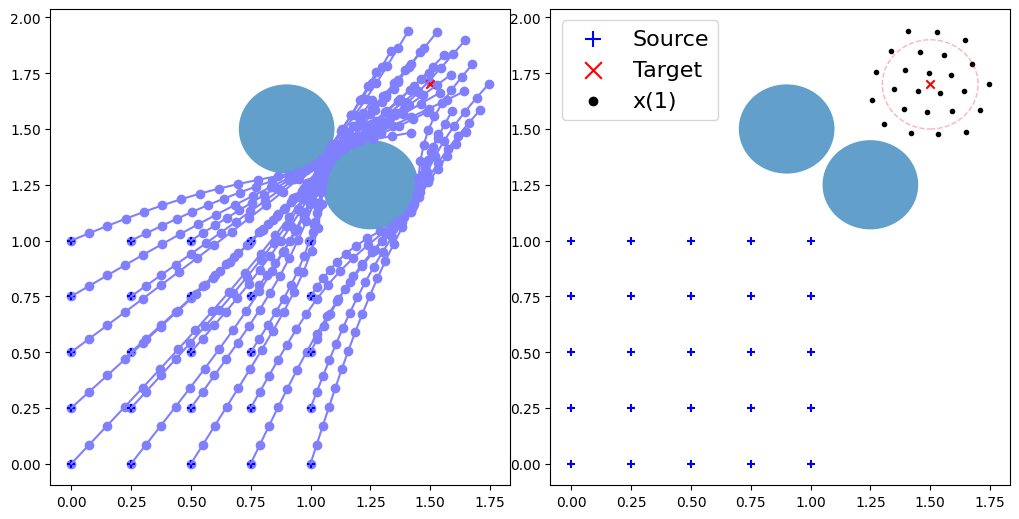

150000


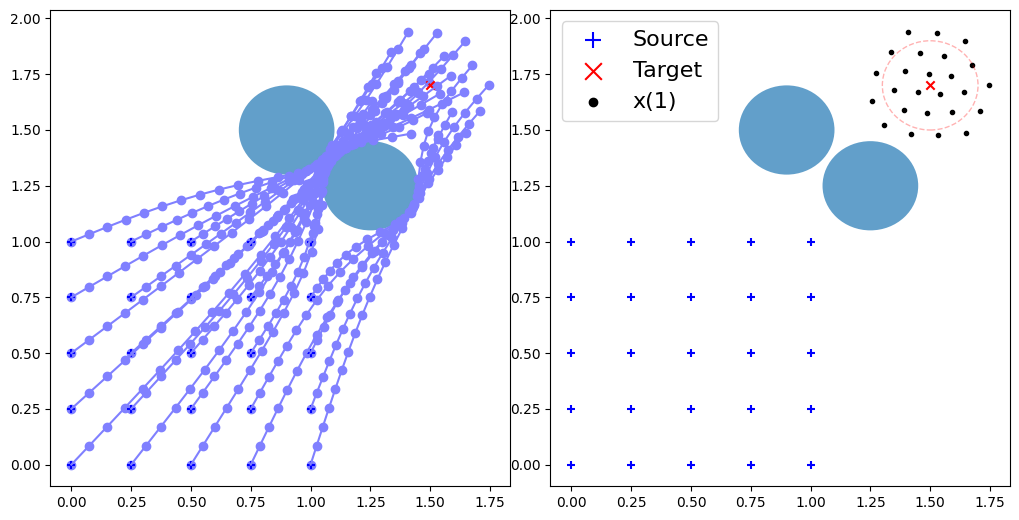

160000


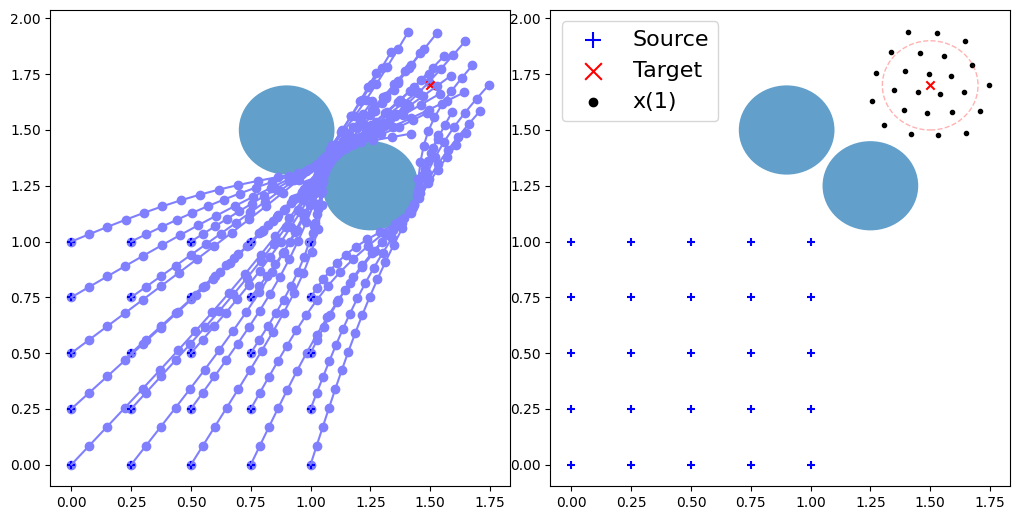

170000


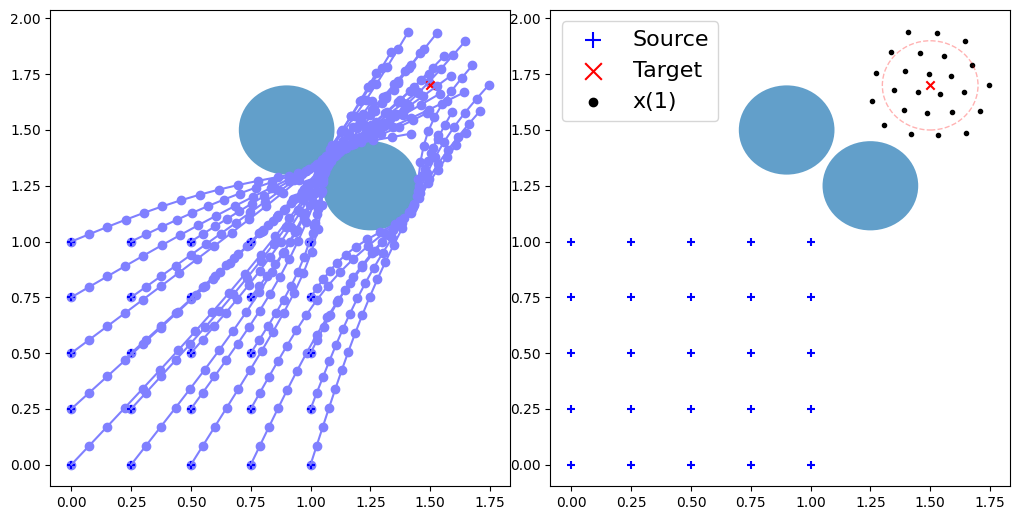

180000


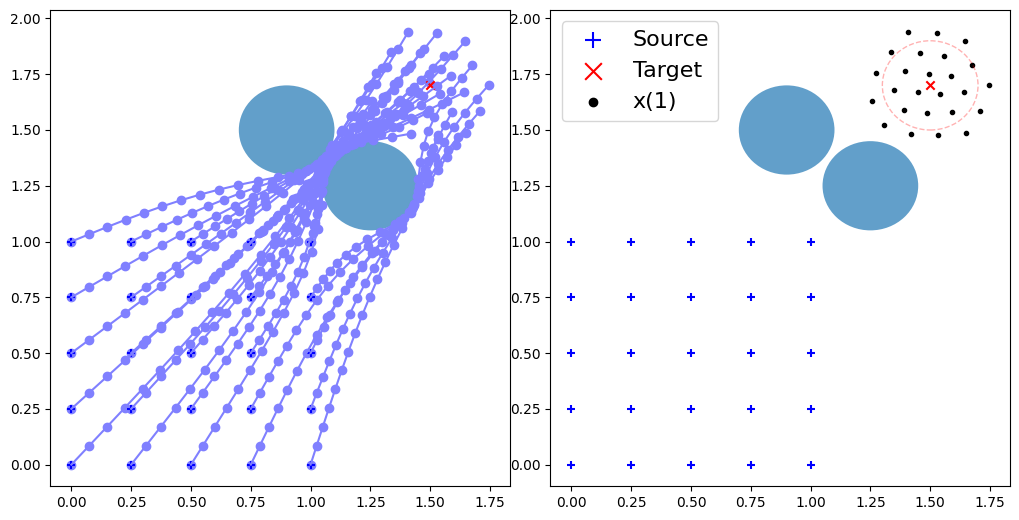

190000


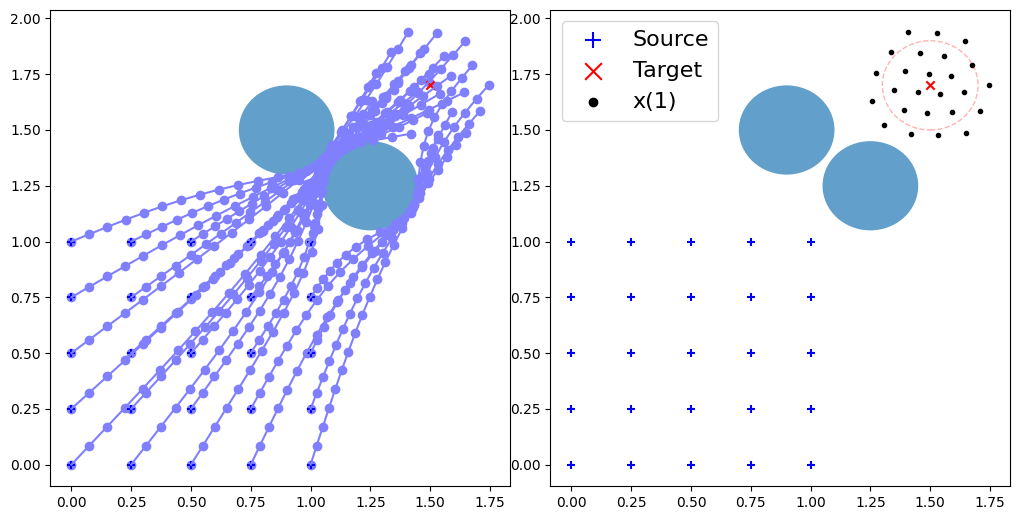

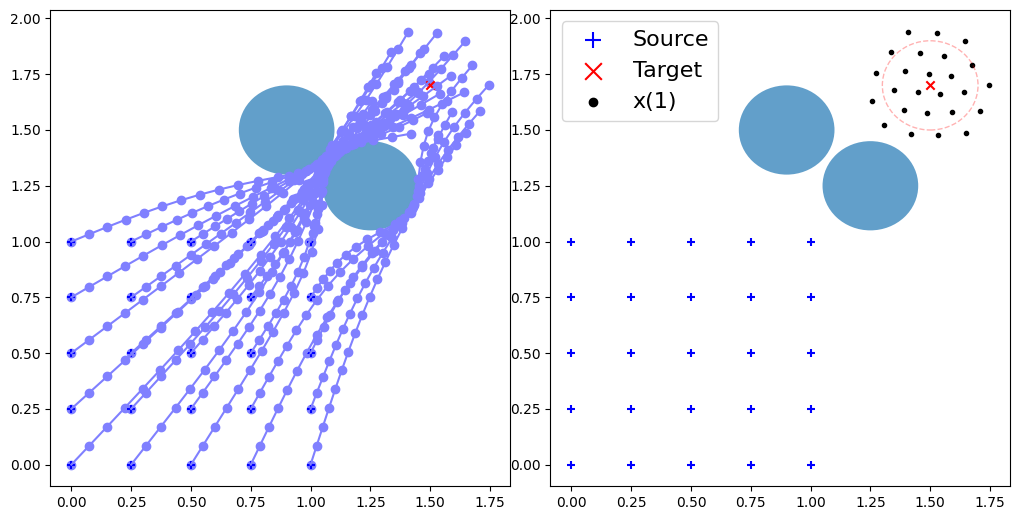

In [ ]:
nx = 5
N = nx**2
d = 2
dt = 0.05
L = int(1/dt)

rng = np.random.RandomState(23)

params = {'N': N, 'd': d, 'dt': dt, 'L': L}

eps  = 0.1
sigma = 0.2
delta = sigma*N**(-0.99/d)

lr = eps/1e3
n = 2*int(1e5)

params.update({'delta': delta, 'eps': eps, 'sigma': sigma, 'lr': lr, 'n': n})

obst_r = 0.2
obst_c1 = (1.25, 1.25)
obst_c2 = (0.9, 1.5)

eps_obst = eps*dt/2

params.update({'obst_r': obst_r, 'obst_c1': obst_c1, 'obst_c2': obst_c2, 'eps_obst': eps_obst})

params['center'] = np.array([1.5, 1.7]).reshape(1, -1)

print(params)

# source, target
z = get_grid_samples(nx)
w = params['center']

z_tensor = torch.from_numpy(z.astype(np.float64))
w_tensor = torch.from_numpy(w.astype(np.float64))

obst1_tensor = torch.from_numpy(np.array(obst_c1).astype(np.float64)).reshape(1,2,1)
obst2_tensor = torch.from_numpy(np.array(obst_c2).astype(np.float64)).reshape(1,2,1)

# initialization
y0 = np.tile(w, [N, 1])
X0 = draw_straight_lines(z, y0, params['L']+1)

# minimize objective function with fancy pytorch optimizers
m = Model(torch.from_numpy(X0.astype(np.float64)), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses = training_loop(m, opt, n=params['n'])

X = m.X.data.cpu().detach().numpy()

plot_2d_paths(X, w, z, params, fname=os.path.join(DRIVE_PATH, FOLDER_PATH, f"obstacles_{date}.pdf"))
plt.show()

In [ ]:
np.savez(os.path.join(DRIVE_PATH, FOLDER_PATH, f'obstacles_{date}.npz'), 
         params=params, w=w, z=z, X=X, allow_pickle=True)


# Plotting

In [ ]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive')
# DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"
# FOLDER_PATH = 'obstacles'

with np.load(os.path.join(DRIVE_PATH, FOLDER_PATH, f'obstacles_{date}.npz'), allow_pickle=True) as data:
    print(data.files)
    params = data['params'][()]
    w = data['w']
    z = data['z']
    X = data['X']
    print(params)

['params', 'w', 'z', 'X', 'allow_pickle']
{'N': 25, 'd': 2, 'dt': 0.05, 'L': 20, 'delta': 0.04064898365069303, 'eps': 0.1, 'sigma': 0.2, 'lr': 0.0001, 'n': 200000, 'obst_r': 0.2, 'obst_c1': (1.25, 1.25), 'obst_c2': (0.9, 1.5), 'eps_obst': 0.0025000000000000005, 'center': array([[1.5, 1.7]])}


In [ ]:
import glob
from PIL import Image

def make_gif_frames(X, w, z, params=None, figsize=(5, 5), trajectory=True, **kwargs):
  if X.shape[-1] <= params['L']:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)
  
  # each frame is time step
  for p in range(0, X.shape[-1]):

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    obst1 = plt.Circle(params['obst_c1'], params['obst_r'], fill=True, alpha=0.7)
    obst2 = plt.Circle(params['obst_c2'], params['obst_r'], fill=True, alpha=0.7)
    ax.add_patch(obst1)
    ax.add_patch(obst2)

    ax.scatter(X[:, 0, 0], X[:, 1, 0], marker='+', c='b', label='Source', alpha=0.6)
    ax.scatter(X[:, 0, p], X[:, 1, p],  color=[0, 0, 0], marker='2', s=100)
    # ax.scatter(X[5,0,p], X[5,1,p],  color=[.5, .5, 1], marker='2', s=100) # if you want to highlight a single particle
    
    ax.scatter(w[:, 0], w[:, 1], marker='x', c='r', label='Target', s=100)   
    circlew = plt.Circle(params['center'].squeeze(), params['sigma'], fill=False, linestyle='--', edgecolor='r', alpha=0.3)
    ax.add_patch(circlew)

    if trajectory:
      # plot trajectory for every particle
      for q in range(X.shape[0]):
        traj = X[q].T
        ax.plot(traj[:p+1, 0], traj[:p+1, 1], color=[0, 0, 0, 0.4])

    plt.ylim([-0.1, 2.1])
    plt.xlim([-0.1, 2.1])
    plt.legend(loc=2)
    plt.tight_layout(pad=0)
    plt.savefig(os.path.join(DRIVE_PATH, FOLDER_PATH, str(p) + '.jpg'), dpi=300)

    plt.close()
  
def make_gif(path=os.path.join(DRIVE_PATH, FOLDER_PATH)):
  
  fnames = glob.glob(os.path.join(path, '*.jpg'))
  # sort by frame number 
  fnames = sorted(fnames, key=lambda x: int(x.rstrip('.jpg').split('/')[-1]))
  frames = [Image.open(image) for image in fnames]
  frames[0].save(os.path.join(path, "obstacles.gif"), format="GIF", append_images=frames,
            save_all=True, duration=300, loop=0)
  
  # reverse gif
  frames = [Image.open(image) for image in fnames[::-1]]
  frames[0].save(os.path.join(path, "obstacles_reverse.gif"), format="GIF", append_images=frames,
            save_all=True, duration=300, loop=0)
  
  print(fnames)

In [ ]:
make_gif_frames(X, w, z, params, trajectory=False)
make_gif()

['/content/drive/MyDrive/BlobOT-final/obstacles/0.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/1.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/2.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/3.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/4.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/5.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/6.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/7.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/8.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/9.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/10.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/11.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/12.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/13.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/14.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/15.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/16.jpg', '/content/drive/MyDrive/BlobOT-final/obstacles/17.jpg', '